## Load dataset

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


train_separable = pd.read_csv('../../input/A2-ring/A2-ring-separable.txt', sep="\t", header=None)
train_merged = pd.read_csv('../../input/A2-ring/A2-ring-merged.txt', sep="\t", header=None)
test = pd.read_csv('../../input/A2-ring/A2-ring-test.txt', sep="\t", header=None)
columns = ['Feature1', 'Feature2', 'Class']
train_separable.columns, train_merged.columns, test.columns = columns, columns, columns




## MLR Model Training

In [2]:
model = LinearRegression()
X_train = train_separable[['Feature1', 'Feature2']]
y_train = train_separable['Class']
model.fit(X_train, y_train)


LinearRegression()

## Model Evaluation on Test Data

In [3]:
X_test = test[['Feature1', 'Feature2']]
y_test = test['Class']
y_pred = model.predict(X_test)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]

# Calculate classification error
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
classification_error = 100 * (fp + fn) / float(tn + fp + fn + tp)
print(f"Classification Error: {classification_error}%")



Classification Error: 47.11%


## Cross-Validation:

In [4]:
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    model.fit(X_train_cv, y_train_cv)
    y_pred_cv = model.predict(X_test_cv)


## Plotting:

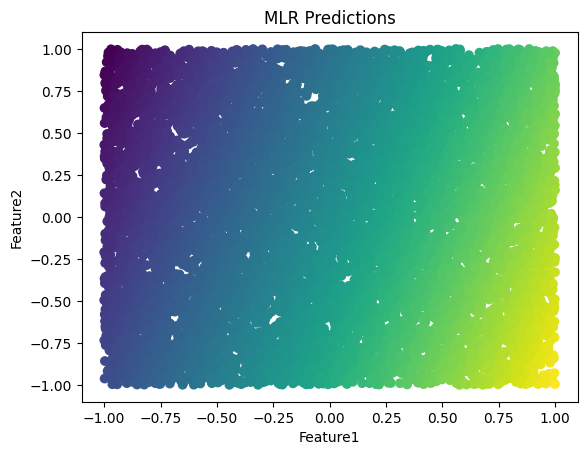

In [5]:


plt.scatter(X_test['Feature1'], X_test['Feature2'], c=y_pred)
plt.title('MLR Predictions')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.show()


## ROC Curve

ROC Curve Points:
Threshold: inf, FPR: 0.000, TPR: 0.000
Threshold: 1.00, FPR: 0.008, TPR: 0.000
Threshold: 0.00, FPR: 1.000, TPR: 1.000

Area Under Curve (AUC): 0.496


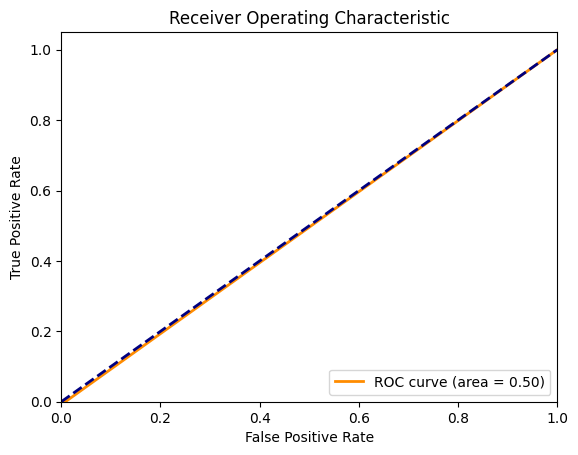

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_binary are defined
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Print ROC Curve Values and Thresholds
print("ROC Curve Points:")
for f, t, th in zip(fpr, tpr, thresholds):
    print(f"Threshold: {th:.2f}, FPR: {f:.3f}, TPR: {t:.3f}")

# Print AUC
print(f"\nArea Under Curve (AUC): {roc_auc:.3f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
